<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: 2.0 Modelling - Obesity Classification Model

> Authors: Michael King Sutanto, Eugene Matthew Cheong, Pius Yee

##### In this notebook 2.0, we will select and tune models for obesity classification.

---
## Table of Contents ##

### Notebook 2.0 Modelling - Obesity Classification Model ###

#### 1. Import Data

[1.1 Import Libraries](#1.1-import-libraries)

[1.2 Import CSV](#1.2-import-csv)

[1.3 Define X and y](#1.3-define-x-and-y)

[1.4 Transform y_train and y_test to Binary](#1.4-transform-y_train-and-y_test-to-binary)

#### 2. Base Modeling

[2.1 Preprocessor Setup Using Column Transformer](#2.1-preprocessor-setup-using-column-transformer)

[2.2 SVM Base Model](#2.2-svm-base-model)

[2.3 Random Forest Base Model](#2.3-random-forest-base-model)

[2.4 XGBoost Base Model](#2.4-xgboost-base-model)

[2.5 Catboost Base Model](#2.5-catboost-base-model)

[2.6 Models Evaluation](#2.6-models-evaluation)

#### 3. Hyperparameter Tuning

[3.1 Catboost Hyperparameter Tuning](#3.1-catboost-hyperparameter-tuning)

[3.2 Train Final Model Using The Best Parameters](#3.2-train-final-model-using-the-best-parameters)

[3.3 Model Evaluation](#3.3-model-evaluation)

[3.4 Comparing Score After Hyperparameter Tuning](#3.4-comparing-score-after-hyperparameter-tuning)

[3.5 Confusion Matrix](#3.5-confusion-matrix)

[3.6 ROC AUC](#3.6-roc-auc)

#### 4. Export Model
[4.1 Export Model PKL](#4.1-export-model-pkl)

#### 5. Summary - Obesity Classification Model
[5.0 Summary](#5.-summary---obesity-classification-model)

---

## 1. Import Data

### 1.1 Import Libraries

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, auc 
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from itertools import cycle

from xgboost import XGBClassifier

from catboost import CatBoostClassifier

### 1.2 Import CSV

In [35]:
# import cleaned dataset for obesity
df = pd.read_csv('../datasets/obesity_level_clean.csv')
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,obesity_status
0,Male,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,Sometimes,0,2.763573,0,0.000000,0.976473,Sometimes,Public_Transportation,overweight
1,Female,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,Frequently,0,2.000000,0,1.000000,1.000000,Never,Automobile,normal
2,Female,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,Sometimes,0,1.910378,0,0.866045,1.673584,Never,Public_Transportation,underweight
3,Female,20.952737,1.710730,131.274851,1,1,3.000000,3.000000,Sometimes,0,1.674061,0,1.467863,0.780199,Sometimes,Public_Transportation,obesity_class_3
4,Male,31.641081,1.914186,93.798055,1,1,2.679664,1.971472,Sometimes,0,1.979848,0,1.967973,0.931721,Sometimes,Public_Transportation,overweight


### 1.3 Define X and y

In [36]:
# create a new list for Numeric columns
num_col = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

In [37]:
# Create a new list for Categorical columns
cat_col = [i for i in list(df.columns) if i not in num_col]
cat_col

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS',
 'obesity_status']

In [38]:
# obesity_status is the target(y)
df['obesity_status'].unique()

array(['overweight', 'normal', 'underweight', 'obesity_class_3',
       'obesity_class_2', 'obesity_class_1'], dtype=object)

In [39]:
X = df.drop(columns='obesity_status') # drop the target
y = df['obesity_status']

In [40]:
# Train Test Split with stratify = y
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)

### 1.4 Transform y_train and y_test to Binary

In [41]:
y_train.unique()

array(['obesity_class_2', 'normal', 'overweight', 'obesity_class_3',
       'obesity_class_1', 'underweight'], dtype=object)

In [42]:
# convert categorical string in y to numeric
obesity_mapping = {'underweight': 0 ,'normal': 1 ,'overweight': 2 ,'obesity_class_1': 3 ,'obesity_class_2': 4 ,'obesity_class_3': 5}

# map to both y train and y test
y_train_num = y_train.map(obesity_mapping)
y_test_num = y_test.map(obesity_mapping)

In [43]:
# y consists of the following classes
y_class = ['underweight','normal','overweight','obesity_class_1','obesity_class_2','obesity_class_3']

---
## 2. Base Modeling

##### Initially, we will build several baseline models and assess their scores.  The best-performing model will then be selected for further tuning and ultimately become our final model.

##### For the base models, we used SVM, Random Forest,XGBoost and Catboost.

### 2.1 Preprocessor Setup Using Column Transformer

In [44]:
# Set one hot enconding and standard scaler columns
ohe_col = ['Gender', 'CAEC', 'CALC', 'MTRANS']
ss_col = num_col #columns for standard scalar

In [45]:
# Instantiating OHE, SS and CT
ohe = OneHotEncoder()
ss = StandardScaler()
ct = make_column_transformer(
    (ohe, ohe_col),
    (ss, ss_col),
    remainder='passthrough'  # Do not transform the remaining columns
)

### 2.2 SVM Base Model

In [46]:
%%time
pipe_svm = Pipeline([
    ('ct', ct),
    ('svm', SVC(random_state=42))
])

pipe_svm.fit(X_train, y_train_num)

CPU times: user 1.76 s, sys: 70.5 ms, total: 1.83 s
Wall time: 3.37 s


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Gender', 'CAEC', 'CALC',
                                                   'MTRANS']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['Age', 'Height', 'Weight',
                                                   'FCVC', 'NCP', 'CH2O', 'FAF',
                                                   'TUE'])])),
                ('svm', SVC(random_state=42))])

### 2.3 Random Forest Base Model

In [47]:
%%time
pipe_rf = Pipeline([
    ('ct', ct),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_rf.fit(X_train, y_train_num)

CPU times: user 1.3 s, sys: 48.6 ms, total: 1.34 s
Wall time: 1.68 s


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Gender', 'CAEC', 'CALC',
                                                   'MTRANS']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['Age', 'Height', 'Weight',
                                                   'FCVC', 'NCP', 'CH2O', 'FAF',
                                                   'TUE'])])),
                ('rf', RandomForestClassifier(random_state=42))])

### 2.4 XGBoost Base Model

In [48]:
%%time
pipe_xgb = Pipeline([
    ('ct', ct),
    ('xgb', XGBClassifier(random_state=42))
])

pipe_xgb.fit(X_train, y_train_num)

CPU times: user 2.88 s, sys: 1.51 s, total: 4.39 s
Wall time: 1.17 s


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Gender', 'CAEC', 'CALC',
                                                   'MTRANS']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['Age', 'Height', 'Weight',
                                                   'FCVC', 'NCP', 'CH2O', 'FAF',
                                                   'TUE'])])),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=No...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

### 2.5 Catboost Base Model

In [49]:
%%time
pipe_cat = Pipeline([
    ('ct', ct),
    ('cat', CatBoostClassifier(random_state=42))
])

pipe_cat.fit(X_train, y_train_num)

Learning rate set to 0.091018
0:	learn: 1.5298927	total: 15.5ms	remaining: 15.4s
1:	learn: 1.3375178	total: 25ms	remaining: 12.5s
2:	learn: 1.2008818	total: 37.4ms	remaining: 12.4s
3:	learn: 1.0909592	total: 45.8ms	remaining: 11.4s
4:	learn: 1.0010543	total: 54.8ms	remaining: 10.9s
5:	learn: 0.9226280	total: 63ms	remaining: 10.4s
6:	learn: 0.8570828	total: 72.1ms	remaining: 10.2s
7:	learn: 0.7968681	total: 80.7ms	remaining: 10s
8:	learn: 0.7467554	total: 88.6ms	remaining: 9.75s
9:	learn: 0.7032911	total: 99.3ms	remaining: 9.83s
10:	learn: 0.6649164	total: 107ms	remaining: 9.63s
11:	learn: 0.6294639	total: 114ms	remaining: 9.42s
12:	learn: 0.5977750	total: 122ms	remaining: 9.29s
13:	learn: 0.5709367	total: 132ms	remaining: 9.31s
14:	learn: 0.5474605	total: 140ms	remaining: 9.18s
15:	learn: 0.5253963	total: 148ms	remaining: 9.09s
16:	learn: 0.5053105	total: 156ms	remaining: 9.01s
17:	learn: 0.4879456	total: 165ms	remaining: 8.98s
18:	learn: 0.4723986	total: 173ms	remaining: 8.92s
19:	lea

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Gender', 'CAEC', 'CALC',
                                                   'MTRANS']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['Age', 'Height', 'Weight',
                                                   'FCVC', 'NCP', 'CH2O', 'FAF',
                                                   'TUE'])])),
                ('cat',
                 <catboost.core.CatBoostClassifier object at 0x166812a10>)])

### 2.6 Models Evaluation

##### We will select the best model from the base model and further hypertuning it.

In [50]:
models = [pipe_svm, pipe_rf, pipe_xgb, pipe_cat]

In [51]:
for model in models:
    # Train Accuracy
    acc_train = accuracy_score(y_train_num, model.predict(X_train))
    
    # Test Accuracy
    acc_test = accuracy_score(y_test_num, model.predict(X_test))
    
    # Sensitivity
    cm = confusion_matrix(y_test_num, model.predict(X_test))

    sensitivity_per_class = {}
    for i in range(len(cm)):
        sensitivity_per_class[y_class[i]] = cm[i, i] / sum(cm[i, :])

    sensitivity = sum(sensitivity_per_class.values())/len(y_class)
    
    # Print results
    print(f'The training accuracy for {str(model.steps[1][0])} is: {round(acc_train,4)}')
    print(f'The test accuracy for {str(model.steps[1][0])} is: {round(acc_test,4)}')
    print(f'The sensitivity for {str(model.steps[1][0])} is: {round(sensitivity,4)} \n')

The training accuracy for svm is: 0.9266
The test accuracy for svm is: 0.9121
The sensitivity for svm is: 0.9078 

The training accuracy for rf is: 1.0
The test accuracy for rf is: 0.9227
The sensitivity for rf is: 0.9188 

The training accuracy for xgb is: 0.9922
The test accuracy for xgb is: 0.9291
The sensitivity for xgb is: 0.9265 

The training accuracy for cat is: 0.9726
The test accuracy for cat is: 0.9299
The sensitivity for cat is: 0.9268 



Summary of the results:

| Model         | Processing Time |  Train Score | Test Score | Sensitivity | 
|:-------------:|:--------:|:--------:|:---------:|:---------:|
| SVM           |  1.2s    |  0.9266  |  0.9121   |  0.9078   |
| Random Forest |  1.2s    |  1.0000  |  0.9227   |  0.9188   |
| XGBoost       |  1.0s    |  0.9922  |  0.9291   |  0.9265   |
| Catboost      |  7.4s    |  0.9726  |  0.9299   |  0.9268   |


##### Since we're dealing with health, we want to use sensitivity as metrics.  
##### We want to minimize false negative as much as possible.  

##### Catboost is the best with the highest sensitivity score, hence we selected it as the final model.

## 3. Hyperparameter Tuning

### 3.1 Catboost Hyperparameter Tuning

In [52]:
# First attemp params.
# pipe_params = {
#     'cat__learning_rate': [0.01, 0.1, 0.5],
#     'cat__depth': [4, 6, 10],
#     'cat__iterations': [100, 500, 1000]
# }

To save time and resources, we conduct grid searches in smaller chunks through an iterative process.  
Above code is the first attempt of grid search.  

In [53]:
pipe_params = {
    'cat__learning_rate': [0.07, 0.1, 0.13],
    'cat__depth': [4],
    'cat__iterations': [1500]
}

In [54]:
gs = GridSearchCV(
    estimator = pipe_cat,
    param_grid = pipe_params,
    cv = 3
)

In [55]:
%%time
gs.fit(X_train, y_train_num)

0:	learn: 1.6090018	total: 40.3ms	remaining: 1m
1:	learn: 1.4733451	total: 47.7ms	remaining: 35.8s
2:	learn: 1.3635997	total: 55.4ms	remaining: 27.6s
3:	learn: 1.2691549	total: 61.1ms	remaining: 22.9s
4:	learn: 1.1918497	total: 67.8ms	remaining: 20.3s
5:	learn: 1.1212216	total: 75.3ms	remaining: 18.7s
6:	learn: 1.0643971	total: 91.4ms	remaining: 19.5s
7:	learn: 1.0149254	total: 102ms	remaining: 19s
8:	learn: 0.9667889	total: 111ms	remaining: 18.3s
9:	learn: 0.9211968	total: 116ms	remaining: 17.4s
10:	learn: 0.8796338	total: 124ms	remaining: 16.8s
11:	learn: 0.8496038	total: 133ms	remaining: 16.5s
12:	learn: 0.8153531	total: 140ms	remaining: 16s
13:	learn: 0.7884406	total: 153ms	remaining: 16.2s
14:	learn: 0.7596677	total: 166ms	remaining: 16.4s
15:	learn: 0.7364298	total: 181ms	remaining: 16.8s
16:	learn: 0.7118901	total: 189ms	remaining: 16.5s
17:	learn: 0.6867584	total: 198ms	remaining: 16.3s
18:	learn: 0.6654802	total: 207ms	remaining: 16.1s
19:	learn: 0.6456549	total: 219ms	remaini

21:	learn: 0.6098308	total: 243ms	remaining: 16.3s
22:	learn: 0.5958492	total: 253ms	remaining: 16.2s
23:	learn: 0.5806162	total: 259ms	remaining: 15.9s
24:	learn: 0.5653463	total: 265ms	remaining: 15.6s
25:	learn: 0.5527056	total: 273ms	remaining: 15.5s
26:	learn: 0.5409425	total: 279ms	remaining: 15.2s
27:	learn: 0.5325613	total: 295ms	remaining: 15.5s
28:	learn: 0.5233182	total: 304ms	remaining: 15.4s
29:	learn: 0.5116773	total: 310ms	remaining: 15.2s
30:	learn: 0.5036724	total: 316ms	remaining: 15s
31:	learn: 0.4936752	total: 322ms	remaining: 14.8s
32:	learn: 0.4855361	total: 329ms	remaining: 14.6s
33:	learn: 0.4772246	total: 339ms	remaining: 14.6s
34:	learn: 0.4695288	total: 346ms	remaining: 14.5s
35:	learn: 0.4634275	total: 353ms	remaining: 14.3s
36:	learn: 0.4589625	total: 368ms	remaining: 14.5s
37:	learn: 0.4518552	total: 376ms	remaining: 14.4s
38:	learn: 0.4465635	total: 384ms	remaining: 14.4s
39:	learn: 0.4402510	total: 392ms	remaining: 14.3s
40:	learn: 0.4336414	total: 399ms

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['Gender',
                                                                          'CAEC',
                                                                          'CALC',
                                                                          'MTRANS']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Height',
                                                                          'Weight',
                                                                          'FCVC',
                                                                          'NCP',
                                                                          'CH2O',
                                                                          'FAF',
                                                                          'TUE'])])),
                                       ('cat',
                                        <catboost.core.CatBoostClassifier object at 0x166812a10>)]),
             param_grid={'cat__depth': [4], 'cat__iterations': [1500],
                         'cat__learning_rate': [0.07, 0.1, 0.13]})

##### Based on the hyperparameter, we found the best params as below:-

In [56]:
gs.best_params_

{'cat__depth': 4, 'cat__iterations': 1500, 'cat__learning_rate': 0.07}

### 3.2 Train Final Model Using The Best Parameters

##### We train the final model based on the best parameters above

In [57]:
%%time
pipe_cat_tuned = Pipeline([
    ('ct', ct),
    ('cat', CatBoostClassifier(depth=4, learning_rate=0.07, iterations=1500, random_state=42))
])

pipe_cat_tuned.fit(X_train, y_train_num)

0:	learn: 1.6041702	total: 5.27ms	remaining: 7.9s
1:	learn: 1.4606261	total: 14.1ms	remaining: 10.6s
2:	learn: 1.3519752	total: 28.1ms	remaining: 14s
3:	learn: 1.2600186	total: 35ms	remaining: 13.1s
4:	learn: 1.1777700	total: 42.7ms	remaining: 12.8s
5:	learn: 1.1095169	total: 49.9ms	remaining: 12.4s
6:	learn: 1.0526437	total: 61.1ms	remaining: 13s
7:	learn: 0.9991549	total: 66.8ms	remaining: 12.5s
8:	learn: 0.9544297	total: 71.6ms	remaining: 11.9s
9:	learn: 0.9085948	total: 78.9ms	remaining: 11.8s
10:	learn: 0.8691762	total: 84.5ms	remaining: 11.4s
11:	learn: 0.8341987	total: 91.6ms	remaining: 11.4s
12:	learn: 0.8017163	total: 97.3ms	remaining: 11.1s
13:	learn: 0.7739623	total: 101ms	remaining: 10.8s
14:	learn: 0.7462745	total: 107ms	remaining: 10.6s
15:	learn: 0.7196095	total: 111ms	remaining: 10.3s
16:	learn: 0.6966549	total: 117ms	remaining: 10.2s
17:	learn: 0.6751391	total: 122ms	remaining: 10.1s
18:	learn: 0.6564368	total: 127ms	remaining: 9.91s
19:	learn: 0.6388234	total: 132ms	r

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Gender', 'CAEC', 'CALC',
                                                   'MTRANS']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['Age', 'Height', 'Weight',
                                                   'FCVC', 'NCP', 'CH2O', 'FAF',
                                                   'TUE'])])),
                ('cat',
                 <catboost.core.CatBoostClassifier object at 0x1669d4090>)])

In [58]:
y_pred = pipe_cat_tuned.predict(X_test)
y_pred = [y_class[i[0]] for i in y_pred]
y_pred

['overweight',
 'obesity_class_1',
 'normal',
 'obesity_class_2',
 'underweight',
 'normal',
 'obesity_class_1',
 'obesity_class_3',
 'normal',
 'obesity_class_2',
 'normal',
 'obesity_class_3',
 'overweight',
 'obesity_class_3',
 'overweight',
 'normal',
 'obesity_class_3',
 'obesity_class_3',
 'underweight',
 'normal',
 'obesity_class_3',
 'normal',
 'normal',
 'obesity_class_3',
 'normal',
 'underweight',
 'obesity_class_3',
 'obesity_class_1',
 'underweight',
 'normal',
 'underweight',
 'obesity_class_2',
 'underweight',
 'overweight',
 'overweight',
 'obesity_class_2',
 'obesity_class_2',
 'obesity_class_1',
 'obesity_class_2',
 'underweight',
 'obesity_class_3',
 'obesity_class_1',
 'overweight',
 'obesity_class_2',
 'obesity_class_2',
 'obesity_class_3',
 'obesity_class_2',
 'normal',
 'obesity_class_2',
 'overweight',
 'obesity_class_3',
 'overweight',
 'normal',
 'overweight',
 'obesity_class_3',
 'overweight',
 'obesity_class_2',
 'obesity_class_1',
 'obesity_class_3',
 'unde

### 3.3 Model Evaluation

In [59]:
# Train Accuracy
acc_train = accuracy_score(y_train_num, pipe_cat_tuned.predict(X_train))
    
# Test Accuracy
acc_test = accuracy_score(y_test_num, pipe_cat_tuned.predict(X_test))
    
# Sensitivity
cm = confusion_matrix(y_test_num, pipe_cat_tuned.predict(X_test))

sensitivity_per_class = {}
for i in range(len(cm)):
    sensitivity_per_class[y_class[i]] = cm[i, i] / sum(cm[i, :])

sensitivity = sum(sensitivity_per_class.values())/len(y_class)
    
# Print results
print(f'The training accuracy for {str(pipe_cat_tuned.steps[1][0])} is: {round(acc_train,4)}')
print(f'The test accuracy for {str(pipe_cat_tuned.steps[1][0])} is: {round(acc_test,4)}')
print(f'The sensitivity for {str(pipe_cat_tuned.steps[1][0])} is: {round(sensitivity,4)} \n')

The training accuracy for cat is: 0.9541
The test accuracy for cat is: 0.9301
The sensitivity for cat is: 0.9271 



### 3.4 Comparing Score After Hyperparameter Tuning

| Model          | Processing Time |  Train Score | Test Score | Sensitivity | 
|:--------------:|:--------:|:--------:|:---------:|:---------:|
| Catboost       |  7.4s    |  0.9726  |  0.9299   |  0.9268   |
| Catboost Tuned |  5.7s    |  0.9541  |  0.9301   |  0.9271   |



After tuning processing time drops.  
Train score drops and test score increases, which means less overfitting and better at generalizing unseen data.  
And Sensitivity increases.

### 3.5 Confusion Matrix

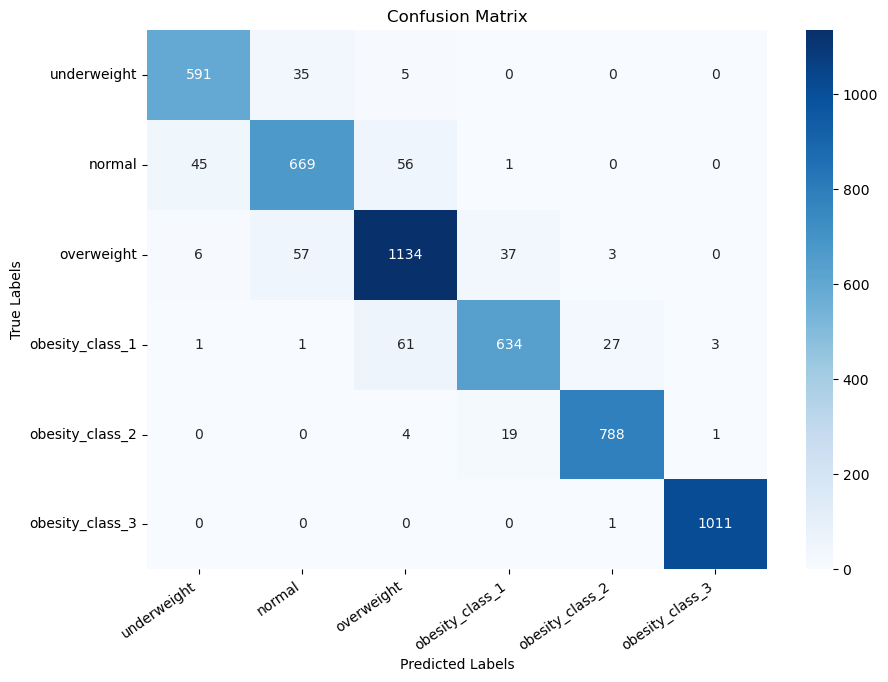

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=y_class, yticklabels=y_class)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=35, ha='right')
plt.show()

### 3.6 ROC AUC

##### Creating ROC AUC plot to evaluate the performance by classes.

In [61]:
# set the probabilities and number of classes
y_prob = pipe_cat_tuned.predict_proba(X_test)
n_classes = len(y_class)

In [62]:
# manually one hot encode the y class
y_test_ohe = []
for i in y_test:
    ohe = [0,0,0,0,0,0]
    ohe[obesity_mapping[i]] = 1
    y_test_ohe.append(ohe)
y_test_ohe = np.array(y_test_ohe)

In [63]:
# for setting the false positive rate and true positive rate by classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_ohe[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

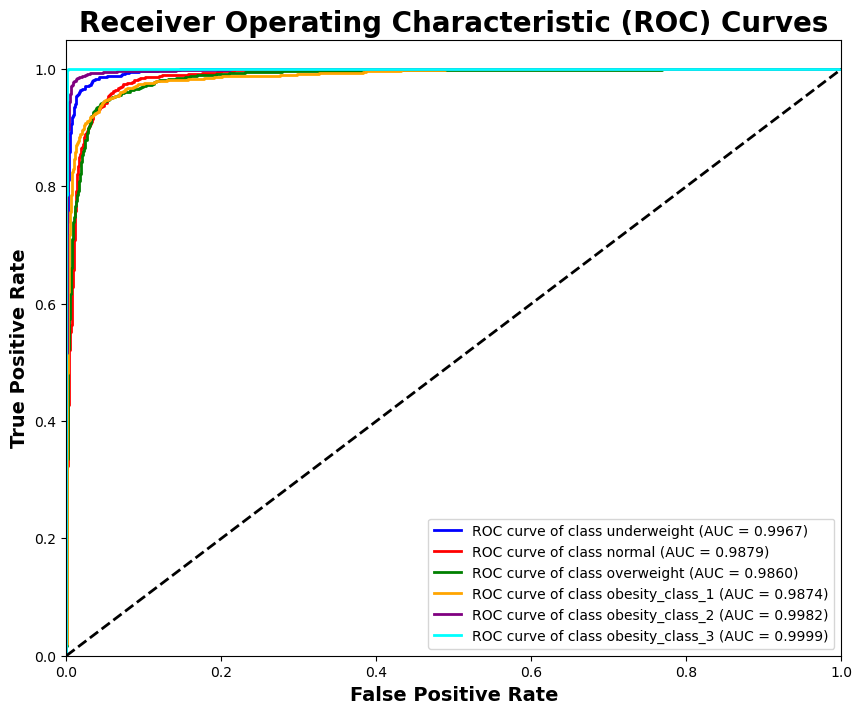

In [64]:
# Plot all ROC curves
plt.figure(figsize=(10, 8))

colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'brown'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.4f})'
             ''.format(y_class[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, weight='bold')
plt.ylabel('True Positive Rate', fontsize=14, weight='bold')
plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=20, weight="bold")
plt.legend(loc="lower right")
plt.show()

##### We can see that model is robust accross all the thresholds for all the classes.

## 4. Export Model


##### Export model for streamlit.

### 4.1 Export Model PKL

In [65]:
import pickle

filename = '../models/model_obesity.pkl'

with open(filename, 'wb') as file:
    pickle.dump(pipe_cat_tuned, file)

## 5. Summary - Obesity Classification model


##### The performance of catboost is satisfied to classify the obesity status hence we selected it as our final model for obesity classification model.

##### In the next notebook 2.1, we will build the model for stroke detector.